In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
sns.set_style("white")
test_ratio = 0.1
data_step = 0.005
data_sigma1 = 2
data_sigma2 = 1
def func(x):
    return np.power(x, 3)

num_data= 1201

data_x = np.linspace(-3, 3, num_data)
data_y = np.zeros(num_data)
data_y_true = np.zeros(num_data)

In [4]:
for i in range(num_data):
    if (data_x[i] < 0):  # -3 <= x <0, sigma=2 (has more uncertainty inherently)
        data_y[i] = func(data_x[i]) + np.random.normal(0, data_sigma1)
    else:  # x>0, sigma=1 (less noisy measurement)
        data_y[i] = func(data_x[i]) + np.random.normal(0, data_sigma2)
        
    data_y_true[i] = func(data_x[i])

In [5]:
num_train_data = int(num_data * (1 - test_ratio))
num_test_data  = num_data - num_train_data

data_x = np.reshape(data_x, [num_data, 1])
data_y = np.reshape(data_y, [num_data, 1])
data_y_true = np.reshape(data_y_true, [num_data, 1])

train_x = data_x[:num_train_data, :]
train_y = data_y[:num_train_data, :]
test_x  = data_x[num_train_data:, :]
test_y  = data_y[num_train_data:, :]

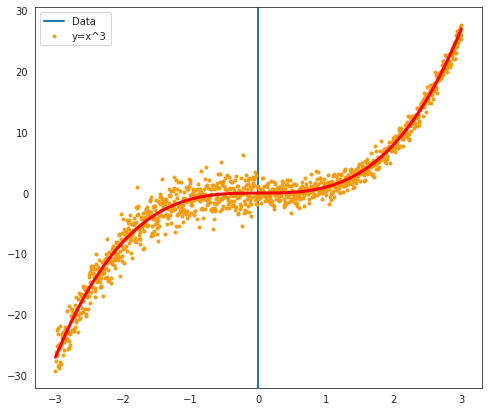

In [6]:
plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
plt.plot(data_x, data_y, '.', markersize=6, color='#F39C12')
plt.plot(data_x, data_y_true, 'r', linewidth=3)
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def gaussian_nll(mu, sigma, y):
    return torch.mean((torch.log(sigma) * 0.5) + ((0.5 * (y - mu).square()) / sigma)) + 1e-6
        
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(self.input_dim, 100)
        self.fc2 = nn.Linear(100, self.output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
class GaussianMultiLayerPerceptron(MultiLayerPerceptron):
    
    def __init__(self, input_dim, output_dim=2):
        super().__init__(input_dim, output_dim)
 
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        mean, variance = torch.split(x, 1, dim=1)
        variance = F.softplus(variance) + 1e-6 #Positive constraint
        return mean, variance

In [8]:
from torch.utils.data import TensorDataset, DataLoader
tensor_x = torch.Tensor(train_x) # transform to torch tensor
tensor_y = torch.Tensor(train_y)

toy_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
dataloader = DataLoader(toy_dataset) # create your dataloader

In [9]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl

class MLP(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    self.model = MultiLayerPerceptron(1, 1)
    self.loss = nn.MSELoss()
    
  def forward(self, x):
    return self.model(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    x = x.view(x.size(0), -1)
    y_hat = self.model(x)
    loss = self.loss(y_hat, y)
    self.log('train_loss', loss)
    return loss
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
    return optimizer

class GaussianMLP(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    self.model = GaussianMultiLayerPerceptron(1, 2)
    self.loss = gaussian_nll
    
  def forward(self, x):
    return self.model(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    x = x.view(x.size(0), -1)
    mu, sigma = self.model(x)
    loss = self.loss(mu, sigma, y)
    self.log('train_loss', loss)
    return loss
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
    return optimizer

In [59]:
mlp = GaussianMLP()
trainer = pl.Trainer(auto_scale_batch_size='power', gpus=1, max_epochs=50)
trainer.fit(mlp, dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402   
-------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)
/home/douglas/Documents/Git/pytorch-deep-ensembles/env/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: -1it [00:00, ?it/s]

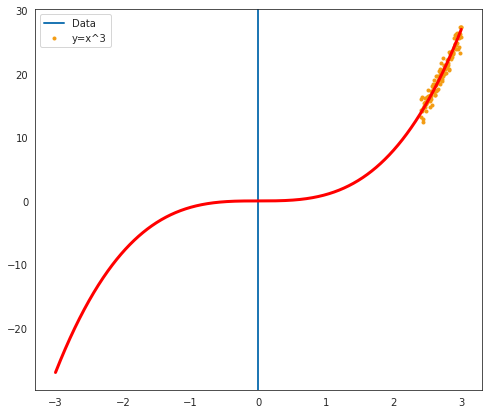

In [60]:
plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
plt.plot(test_x, test_y, '.', markersize=6, color='#F39C12')
plt.plot(data_x, data_y_true, 'r', linewidth=3)
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()

In [76]:
mlp.eval()
preds = []
sigmas = []

for x in data_x:
    mu, sigma = mlp(torch.Tensor(x).unsqueeze(0))
    preds.append(mu.item())
    sigmas.append(sigma.item())

[-3.    -2.995 -2.99  ...  2.99   2.995  3.   ]


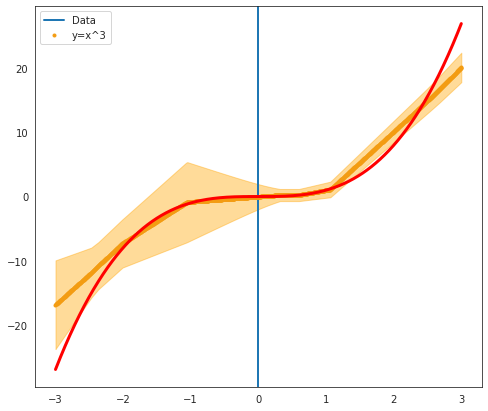

In [82]:
upper = [i + k for i, k in zip(preds, sigmas)]
lower = [i - k for i, k in zip(preds, sigmas)]

plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
plt.plot(data_x, preds, '.', markersize=6, color='#F39C12')
plt.fill_between(data_x.flatten(), upper, lower, color="orange", alpha=0.4)
plt.plot(data_x, data_y_true, 'r', linewidth=3)
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()

In [66]:
mlp.eval()
preds = []

for x in test_x:
    mu, sigma = mlp(torch.Tensor(x).unsqueeze(0))
    preds.append(mu.item())
    sigmas.append(sigma.item())

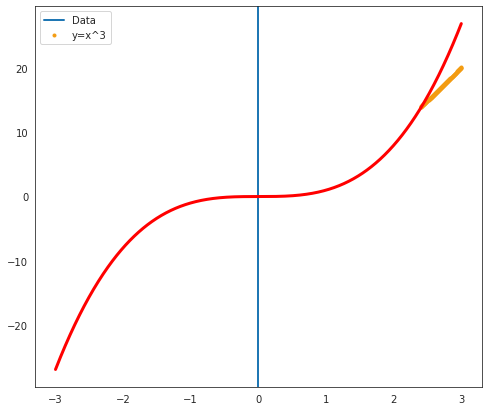

In [68]:
upper = [i+k for i,k in zip(preds, sigmas)]
lower = [i-k for i,k in zip(preds, sigmas)]

plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
plt.plot(test_x, preds, '.', markersize=6, color='#F39C12')
plt.plot(data_x, data_y_true, 'r', linewidth=3)
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()

In [12]:
models = []
import random
import pytorch_lightning as pl

for i in range(5):
    seed = random.randint(0, 9999)
    print(i, seed)
    pl.seed_everything(seed)
    mlp = GaussianMLP()
    trainer = pl.Trainer(auto_scale_batch_size='power', gpus=1, max_epochs=2)
    trainer.fit(mlp, dataloader)
    models.append(mlp)

Global seed set to 3819
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402   
-------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


0 3819


Training: -1it [00:00, ?it/s]

Global seed set to 6770
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402   
-------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


1 6770


Training: -1it [00:00, ?it/s]

Global seed set to 3758
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402   
-------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


2 3758


Training: -1it [00:00, ?it/s]

Global seed set to 8499
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402   
-------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


3 8499


Training: -1it [00:00, ?it/s]

Global seed set to 7408
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402   
-------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


4 7408


Training: -1it [00:00, ?it/s]

In [44]:
import numpy as np
means = []
variances = []

for model in models:
    model.eval()
    preds = []
    sigmas = []

    for x in data_x:
        mu, sigma = model(torch.Tensor(x).unsqueeze(0))
        preds.append(mu.item())
        sigmas.append(sigma.item())
    
    means.append(preds)
    variances.append(sigmas)
means = torch.tensor(means)
variances = torch.tensor(variances)


torch.Size([5, 1201])


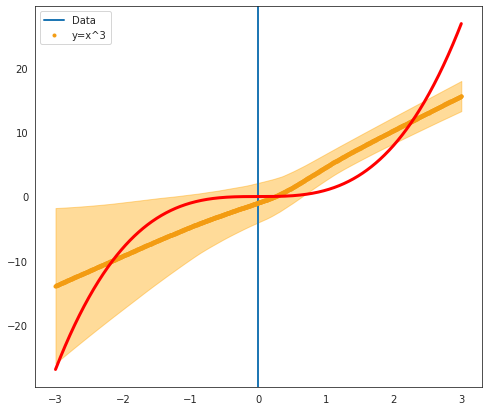

In [49]:
mean = means.mean(0)
variance = (variances +  means.pow(2)).mean(0) - mean.pow(2)

upper = [i + k for i, k in zip(mean.numpy(), variance.numpy())]
lower = [i - k for i, k in zip(mean.numpy(), variance.numpy())]

plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
plt.plot(data_x, mean, '.', markersize=6, color='#F39C12')
plt.fill_between(data_x.flatten(), upper, lower, color="orange", alpha=0.4)
plt.plot(data_x, data_y_true, 'r', linewidth=3)
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()